### Import packages

In [1]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


### Styling and fancy distribution plot

In [2]:
# Plot styling and display options
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 10 , 6

# Special distribution plot (will be used later)
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

### Load Data

In [3]:
# train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
# test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
combine = [train_df, test_df]
# combine is used to ensure whatever preprocessing is done on training data

## Part 2: Preprocessing the Data

In [4]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


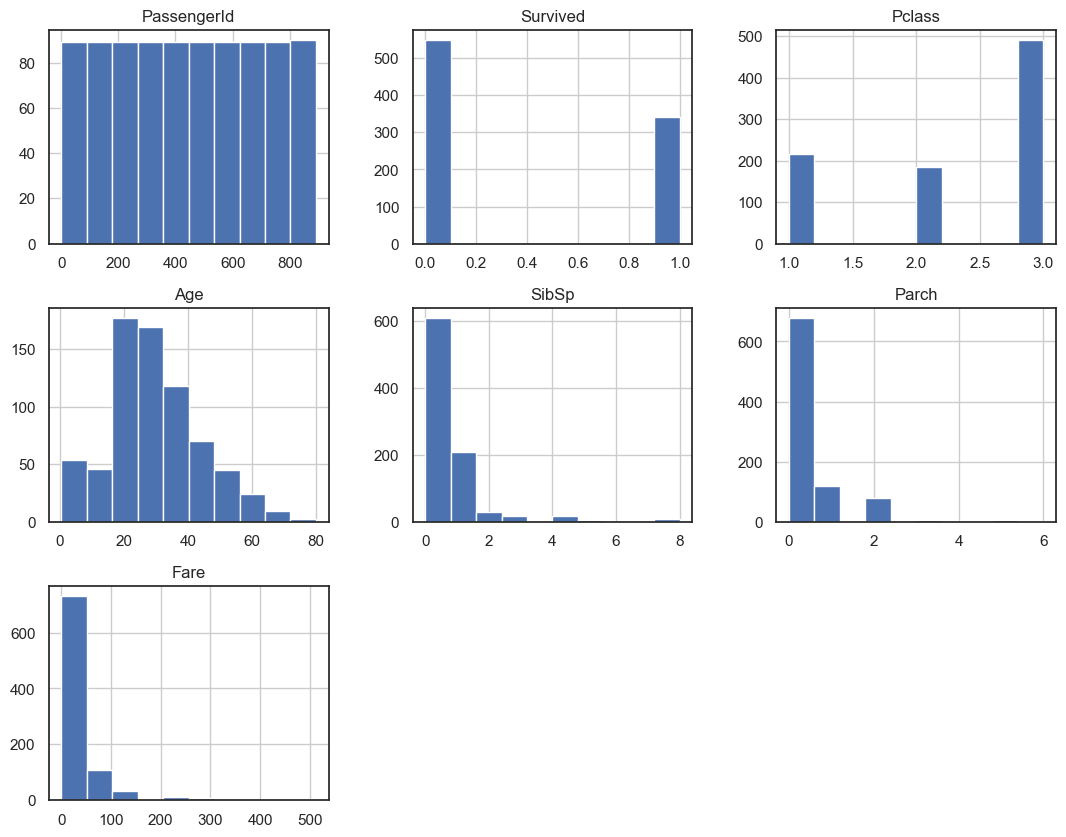

In [8]:
train_df.hist(figsize=(13,10))
plt.show()

In [9]:
train_df[['Pclass', 'Survived']].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [10]:
# Balanced data set?

target_count = train_df['Survived'].value_counts()
target_count

Survived
0    549
1    342
Name: count, dtype: int64

In [11]:
# Baseline for prediction accuracy

target_count[0]/(sum(target_count)) 

0.6161616161616161

In [12]:
train_df = train_df.drop(['PassengerId','Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

In [13]:
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


In [14]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [15]:
train_df.Name[:10]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [16]:
# Extract title of each passenger and save that in a column in the dataset called 'Title'

for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.',\
                                                expand=False)

In [17]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [18]:
# Double check that our titles makes sense (by comparing to sex)
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [19]:
pd.crosstab(test_df['Title'], test_df['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [20]:
# Replace commonn titles with Rare

for dataset in combine:
    dataset['Title'] = dataset['Title'].\
                  replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',\
                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') 
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [21]:
train_df[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


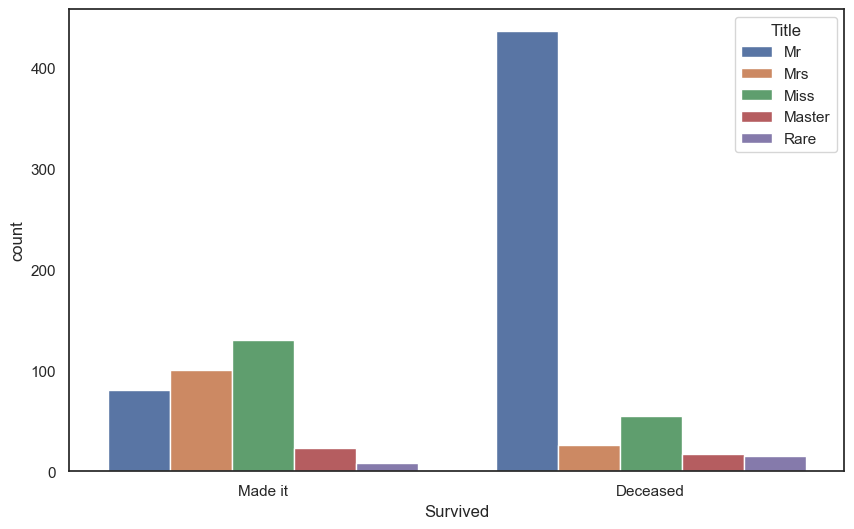

In [22]:
# Plotting survival count for each title

sns.countplot(x='Survived', hue="Title", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it','Deceased']);

In [23]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [24]:
# Mapping titles to binary dummy columns

for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Title,dtype=int)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,0,0,1,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,0,0,0,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,0,1,0,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,0,0,0,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,0,0,1,0,0


In [25]:
# Remove unique variables for analysis

train_df = train_df.drop(['Name', 'Title'], axis=1)
test_df = test_df.drop(['Name', 'Title'], axis=1)
combine = [train_df, test_df]

In [26]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,male,22.0,1,0,7.2500,S,0,0,1,0,0
1,1,1,female,38.0,1,0,71.2833,C,0,0,0,1,0
2,1,3,female,26.0,0,0,7.9250,S,0,1,0,0,0
3,1,1,female,35.0,1,0,53.1000,S,0,0,0,1,0
4,0,3,male,35.0,0,0,8.0500,S,0,0,1,0,0


In [27]:
# One-hot encoding the gender column
for dataset in combine:
    dataset['Sex'] = dataset['Sex']. \
        map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22.0,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,38.0,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,26.0,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,35.0,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,35.0,0,0,8.0500,S,0,0,1,0,0


In [28]:
train_df['Age'].isnull().sum()

177

In [29]:
# Initialize empty array  for later use

guess_ages = np.zeros((2,3),dtype=int) 
guess_ages

array([[0, 0, 0],
       [0, 0, 0]])

In [30]:
for idx,dataset in enumerate(combine):  
    if idx==0:
        print('Working on Training Data set\n')
    else:
        print('-'*35)
        print('Working on Test Data set\n')
    
    print('Guess values of age based on sex and pclass of the passenger...')
    for i in range(0, 2):
        for j in range(0,3):
            guess_df = dataset[(dataset['Sex'] == i) \
                        & (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()
          
    
            guess_ages[i,j] = int(age_guess)
    
            
    print('Guess_Age table:\n',guess_ages)
    print ('\nAssigning age values to NAN age values in the dataset...')
    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) \
                    & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
                    

    dataset['Age'] = dataset['Age'].astype(int)
    print()
print('Done! \n\n\n')
train_df.head()

Working on Training Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[40 30 25]
 [35 28 21]]

Assigning age values to NAN age values in the dataset...

-----------------------------------
Working on Test Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[42 28 24]
 [41 24 22]]

Assigning age values to NAN age values in the dataset...

Done! 





,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,38,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,26,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,35,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,35,0,0,8.0500,S,0,0,1,0,0


In [31]:
# Age bands
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False)\
                    .mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [32]:
# Change Age column to map Age ranges to integer values of categorical type 

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 1
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 64, 'Age']=5
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,AgeBand
0,0,3,0,2,1,0,7.2500,S,0,0,1,0,0,"(16.0, 32.0]"
1,1,1,1,3,1,0,71.2833,C,0,0,0,1,0,"(32.0, 48.0]"
2,1,3,1,2,0,0,7.9250,S,0,1,0,0,0,"(16.0, 32.0]"
3,1,1,1,3,1,0,53.1000,S,0,0,0,1,0,"(32.0, 48.0]"
4,0,3,0,3,0,0,8.0500,S,0,0,1,0,0,"(32.0, 48.0]"


In [33]:
# Drop AgeBand column

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,2,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,3,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,2,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,3,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,3,0,0,8.0500,S,0,0,1,0,0


In [34]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    
# Survival chance against FamilySize

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True) \
                                .mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


AttributeError: 'numpy.int64' object has no attribute 'startswith'

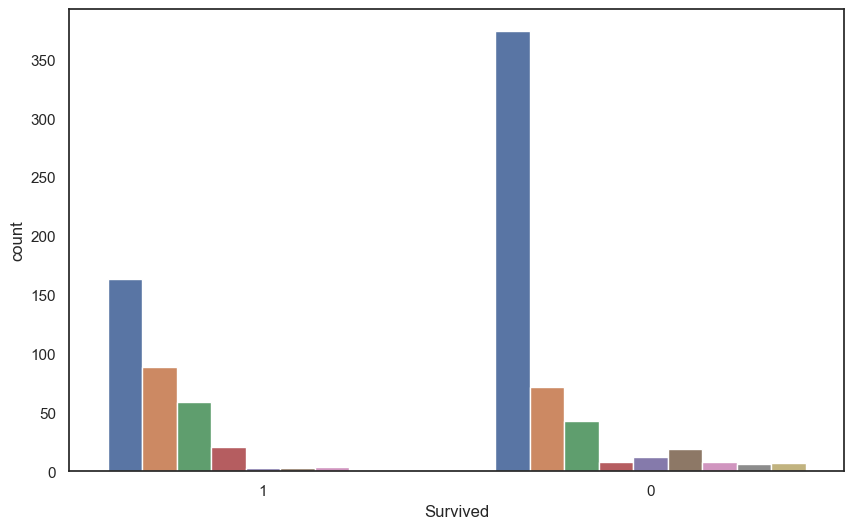

In [35]:
# Plot it, 1 is survived

sns.countplot(x='Survived', hue="FamilySize", data=train_df, order=[1,0]);

In [ ]:
# Encoding FamilySize into categories

for dataset in combine:    
    dataset.loc[ dataset['FamilySize'] <= 16, 'Fsize'] = 1
    dataset.loc[(dataset['FamilySize'] > 1) & (dataset['FamilySize'] <= 4), 'Fsize'] = 2
    dataset.loc[ dataset['FamilySize'] > 4, 'Fsize']= 3
train_df.head()

train_df[['Fsize', 'Survived']].groupby(['Fsize'], as_index=True).mean()

In [ ]:
for df in combine:
    df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1, inplace=True)


train_df.head()

# Part 3: Feature construction

In [36]:
# Create new features based on intuitive combinations

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head()

,Age*Class,Age,Pclass
0,6,2,3
1,3,3,1
2,6,2,3
3,3,3,1
4,9,3,3


In [37]:
train_df[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=True).mean()

,Survived
Age*Class,
1,0.888889
2,0.775000
3,0.526627
4,0.457143
5,0.166667
6,0.269430
8,0.352941
9,0.100000
10,0.000000


In [38]:
# To replace Nan value in 'Embarked', we will use the mode in 'Embaraked'

freq_port = train_df['Embarked'].dropna().mode()[0]
print('Most frequent port of Embarkation:',freq_port)


Most frequent port of Embarkation: S


In [39]:
# Fill NaN 'Embarked' Values in the datasets

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

### Survival relative to port of origin

In [40]:
train_df[['Embarked', 'Pclass', 'Survived']].groupby(['Embarked', 'Pclass'], as_index=True) \
                    .count()

Survived
Embarked Pclass          
C        1             85
         2             17
         3             66
Q        1              2
         2              3
         3             72
S        1            129
         2            164
         3            353

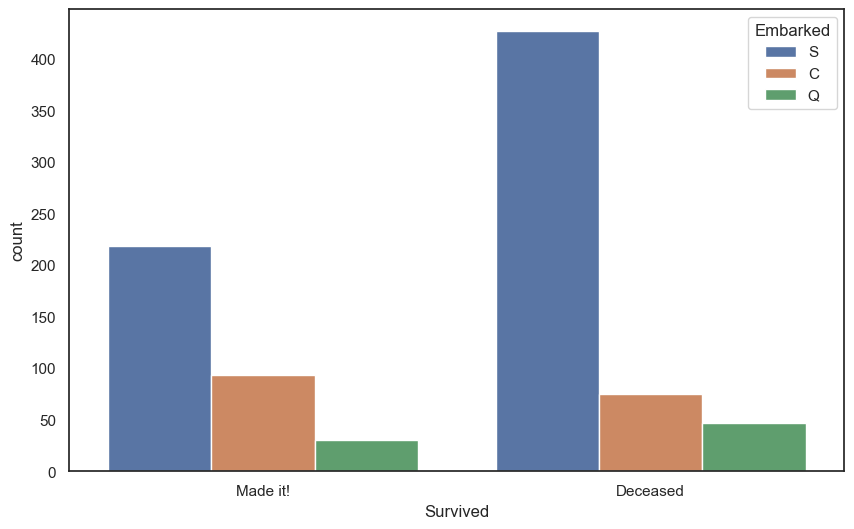

In [41]:
# Plot of relationship between survival and origin 

sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it!', 'Deceased']);


In [42]:
# Create categorical dummy variables for Embarked values

for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Embarked,dtype=int)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded


label_encoder = LabelEncoder()

# Fit and transform the categorical variable
for dataset in combine:
    dataset['Embarked_LabelEncoded'] = label_encoder.fit_transform(dataset['Embarked'])
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,FamilySize,Age*Class,C,Q,S,Embarked_LabelEncoded
0,0,3,0,2,1,0,7.2500,S,0,0,1,0,0,2,6,0,0,1,2
1,1,1,1,3,1,0,71.2833,C,0,0,0,1,0,2,3,1,0,0,0
2,1,3,1,2,0,0,7.9250,S,0,1,0,0,0,1,6,0,0,1,2
3,1,1,1,3,1,0,53.1000,S,0,0,0,1,0,2,3,0,0,1,2
4,0,3,0,3,0,0,8.0500,S,0,0,1,0,0,1,9,0,0,1,2


In [43]:
dataset.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,FamilySize,Age*Class,C,Q,S,Embarked_LabelEncoded
0,892,3,0,3,0,0,7.8292,Q,0,0,1,0,0,1,9,0,1,0,1
1,893,3,1,3,1,0,7.0000,S,0,0,0,1,0,2,9,0,0,1,2
2,894,2,0,4,0,0,9.6875,Q,0,0,1,0,0,1,8,0,1,0,1
3,895,3,0,2,0,0,8.6625,S,0,0,1,0,0,1,6,0,0,1,2
4,896,3,1,2,1,1,12.2875,S,0,0,0,1,0,3,6,0,0,1,2


In [44]:
# Drop Embarked

for dataset in combine:
    dataset.drop('Embarked', axis=1, inplace=True)

In [45]:
for dataset in combine:
    dataset['Embarked*Class'] = dataset.Embarked_LabelEncoded * dataset.Pclass

train_df.loc[:, ['Embarked*Class', 'Pclass']].head()

,Embarked*Class,Pclass
0,6,3
1,0,1
2,6,3
3,2,1
4,6,3


In [46]:
train_df[['Embarked*Class', 'Survived']].groupby(['Embarked*Class'], as_index=True).mean()

,Survived
Embarked*Class,
0,0.553571
1,0.500000
2,0.590909
3,0.375000
4,0.463415
6,0.189802


In [47]:
test_df['Fare'].isnull().sum()

1

In [48]:
# Fill the NA values in the Fares column with the median

test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Master,Miss,Mr,Mrs,Rare,FamilySize,Age*Class,C,Q,S,Embarked_LabelEncoded,Embarked*Class
0,892,3,0,3,0,0,7.8292,0,0,1,0,0,1,9,0,1,0,1,3
1,893,3,1,3,1,0,7.0000,0,0,0,1,0,2,9,0,0,1,2,6
2,894,2,0,4,0,0,9.6875,0,0,1,0,0,1,8,0,1,0,1,2
3,895,3,0,2,0,0,8.6625,0,0,1,0,0,1,6,0,0,1,2,6
4,896,3,1,2,1,1,12.2875,0,0,0,1,0,3,6,0,0,1,2,6


<Axes: >

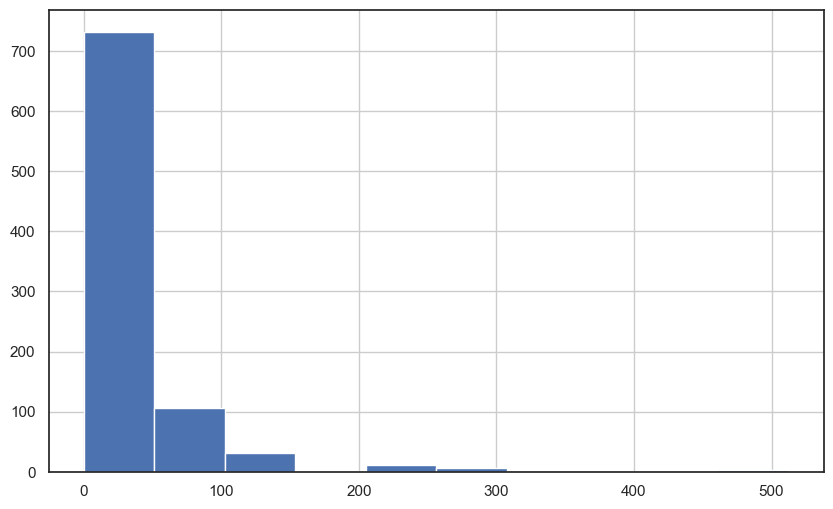

In [49]:
train_df['Fare'].hist()

In [50]:
# q cut will find ranges equal to the quartile of the data

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [51]:
train_fare_bins = pd.qcut(train_df['Fare'], 4, retbins=True)[1] 
train_fare_bins

array([  0.    ,   7.9104,  14.4542,  31.    , 512.3292])

In [52]:
train_fare_bins[0] = train_fare_bins[0]-1

In [53]:
train_fare_bins[-1] = train_fare_bins[-1]+400

In [54]:
train_fare_bins

array([ -1.    ,   7.9104,  14.4542,  31.    , 912.3292])

In [55]:
# Create categorical values for the models to generalize

for dataset in combine:
    dataset['Fare']=pd.cut(dataset['Fare'], bins=train_fare_bins, labels=np.arange(4)).astype(int)

train_df[['Fare','FareBand']].head()

,Fare,FareBand
0,0,"(-0.001, 7.91]"
1,3,"(31.0, 512.329]"
2,1,"(7.91, 14.454]"
3,3,"(31.0, 512.329]"
4,1,"(7.91, 14.454]"


In [56]:
# Drop FareBand

train_df = train_df.drop(['FareBand', 'Embarked_LabelEncoded'], axis=1)
test_df = test_df.drop(['Embarked_LabelEncoded'], axis=1)
combine = [train_df, test_df]

### Sanity Check: View the correlation between features in our processed dataset

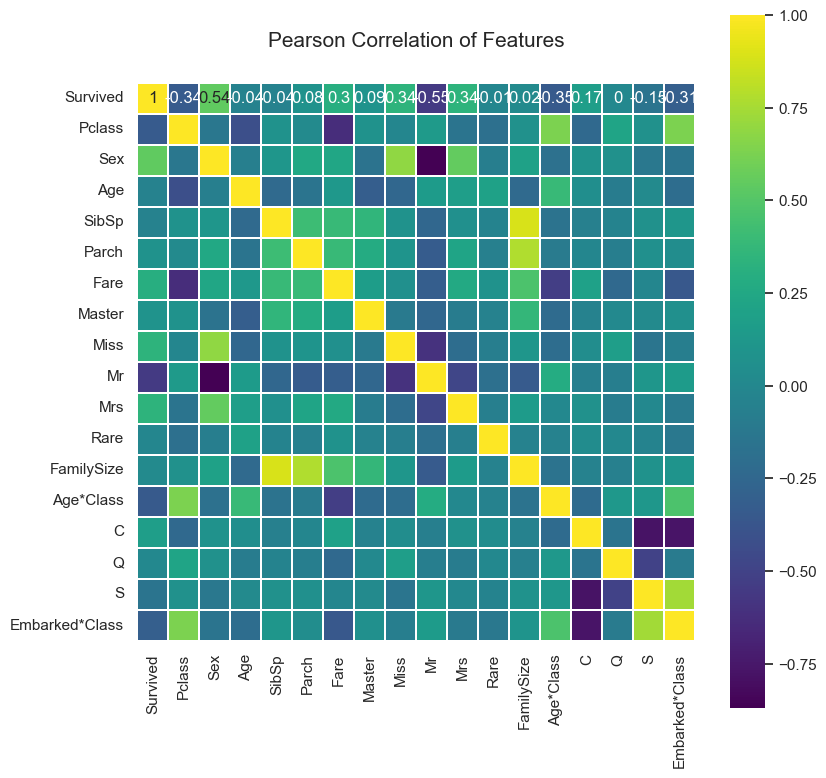

In [57]:
# Uncorrelated features are generally more powerful predictors

colormap = plt.cm.viridis
plt.figure(figsize=(9,9))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

## Part 4: Machine Learning

In [58]:
X = train_df.drop("Survived", axis=1) # Training & Validation data
Y = train_df["Survived"]              # Response / Target Variable

X_submission  = test_df.drop("PassengerId", axis=1).copy()

print(X.shape, Y.shape)

(891, 17) (891,)


In [59]:
# Split training set so that we validate on 20% of the data

np.random.seed(42) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.17)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(739, 17) (739,)
(152, 17) (152,)


In [62]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=500)   # instantiate
random_forest.fit(X_train, Y_train)                         # fit
acc_rf = random_forest.score(X_val, Y_val)                  # predict + evaluate

print('Random Forest labeling accuracy:', str(round(acc_rf*100,2)),'%')

Random Forest labeling accuracy: 83.55 %


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(42)

# Define the neural network structure
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(15, 300)  # Input layer to first hidden layer
        self.layer2 = nn.Linear(300, 100) # Second hidden layer
        self.layer3 = nn.Linear(100, 50)  # Third hidden layer
        self.output_layer = nn.Linear(50, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

# Instantiate the model, loss function, and optimizer
model = NeuralNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Prepare data (convert numpy arrays to torch tensors)
X_train_torch = torch.from_numpy(X_train.values).float()
Y_train_torch = torch.from_numpy(Y_train.values).float().view(-1, 1)
X_val_torch = torch.from_numpy(X_val.values).float()
Y_val_torch = torch.from_numpy(Y_val.values).float().view(-1, 1)

# Training loop
for epoch in range(50):  # Assuming 50 epochs
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, Y_train_torch)
    loss.backward()
    optimizer.step()
    #print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    predictions = model(X_val_torch)
    predicted_classes = predictions.round()
    accuracy = (predicted_classes.eq(Y_val_torch).sum().float() / len(Y_val_torch)).item()
    print(f'Neural Network accuracy: {accuracy * 100:.2f}%')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (739x17 and 15x300)

#### Tensorflow

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# instantiate

model = Sequential()
model.add( Dense(units=300, activation='relu', input_shape=(15,) ))
model.add( Dense(units=100, activation='relu'))
model.add( Dense(units=50, activation='relu'))
model.add( Dense(units=1, activation='sigmoid') )

In [ ]:
# fit

model.compile(loss = 'binary_crossentropy', optimizer = 'adam',\
              metrics = ['accuracy'])
model.fit(X_train.values, Y_train.values, epochs = 50, batch_size= 50)

In [ ]:
# Evaluate the model Accuracy on test set
print('Neural Network accuracy:',str(round(model.evaluate(X_val.values, \
                Y_val.values, batch_size=50,verbose=False)[1]*100,2)),'%')

In [ ]:
train_df.head()

### Importance scores in the random forest model

In [ ]:
# Look at importnace of features for random forest

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ('Training accuracy Random Forest:',model.score( X , y ))

plot_model_var_imp(random_forest, X_train, Y_train)

In [64]:
# Grid Search to find optimal hyperparameters

from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {'n_estimators': [100, 250, 300, 400, 500, 600, 700],
              'max_depth': [5, 10],
              'min_samples_split': [5, 10],
              'min_samples_leaf': [2, 3, 4]}

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train);

In [65]:
# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict the labels of the val set
y_pred = best_model.predict(X_val)

# Evaluation
acc = accuracy_score(Y_val, y_pred)
prec = precision_score(Y_val, y_pred)
recall = recall_score(Y_val, y_pred)
f1 = f1_score(Y_val, y_pred)

print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", recall)
print("F1-score: ", f1)

Best parameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy:  0.8223684210526315
Precision:  0.8148148148148148
Recall:  0.7213114754098361
F1-score:  0.7652173913043478


In [66]:
from sklearn.metrics import classification_report
print(classification_report(Y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        91
           1       0.81      0.72      0.77        61

    accuracy                           0.82       152
   macro avg       0.82      0.81      0.81       152
weighted avg       0.82      0.82      0.82       152



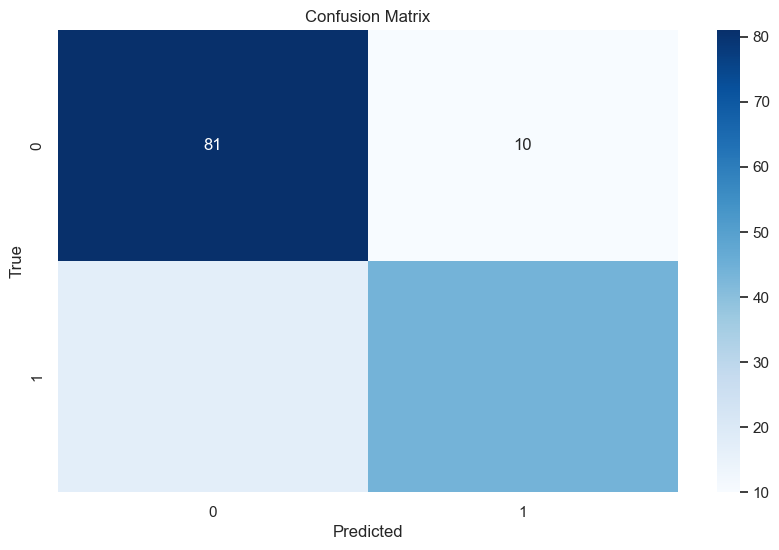

In [67]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(Y_val, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [68]:
# Create a Kaggle submission with a Random Forest Classifier
Y_submission = best_model.predict(X_submission)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_submission
    })
submission.to_csv('titanic.csv', index=False)